In [1]:
!pip install tensorflow-addons==0.10.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.0 MB 1.7 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.13.0
    Uninstalling tensorflow-addons-0.13.0:
      Successfully uninstalled tensorflow-addons-0.13.0


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.cycle_gan import CycleGanDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "cycle_gan"
data_set_name = "HE_IHC_dataset"
batch_size = 4
on_memory = True
argumentation_proba = 0.8
target_size = (512, 512)
interpolation = "bilinear"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/train/*/*")
train_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/train/*/*")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/test/*/*")
test_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/test/*/*")

train_data_loader = CycleGanDataloader(image_path_list=train_image_path_list,
                                       target_image_path_list=train_target_image_path_list,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       dtype=dtype
)
test_data_loader = CycleGanDataloader(image_path_list=test_image_path_list,
                                      target_image_path_list=test_target_image_path_list,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       dtype=dtype
)

100%|██████████| 11000/11000 [01:33<00:00, 117.41it/s]

Source data num 11000, Target data num: 11000
Source data num 3000, Target data num: 3000


In [3]:
from copy import deepcopy

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import sigmoid
from tensorflow.image import ssim
from tensorflow.keras.applications import InceptionV3

import segmentation_models as sm
sm.set_framework ('tf.keras')

from src.util.custom_loss import dice_score
from src.util.loss_cycle_gan import get_channel_weighted_dice_loss, get_channel_weighted_mse_loss
from src.model.cycle_gan import CycleGan

BACKBONE="inceptionv3"
DROPOUT_RATIO = 0.5

optimizer = Nadam(5e-5, beta_1=0.5, clipnorm=1)
input_image_shape = (*target_size, 3)
output_image_shape = (*target_size, 3)

generator_G = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")
generator_F = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")

base_discriminator_X = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)

# (Batch_Size,?)
discriminator_X_output = GlobalAveragePooling2D()(base_discriminator_X.output)
discriminator_X_output = Dropout(DROPOUT_RATIO)(discriminator_X_output)
# let's add a fully-connected layer
# (Batch_Size,1)
discriminator_X_output = Dense(1024, activation='relu')(discriminator_X_output)
# (Batch_Size,1024)
discriminator_X_output = Dropout(DROPOUT_RATIO)(discriminator_X_output)
x_predictions = Dense(1)(discriminator_X_output)

discriminator_X = Model(base_discriminator_X.input, x_predictions)

base_discriminator_Y = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)
# (Batch_Size,?)
discriminator_Y_output = GlobalAveragePooling2D()(base_discriminator_Y.output)
discriminator_Y_output = Dropout(DROPOUT_RATIO)(discriminator_Y_output)
# let's add a fully-connected layer
# (Batch_Size,1)
discriminator_Y_output = Dense(1024, activation='relu')(discriminator_Y_output)
# (Batch_Size,1024)
discriminator_Y_output = Dropout(DROPOUT_RATIO)(discriminator_Y_output)
y_predictions = Dense(1)(discriminator_Y_output)

discriminator_Y = Model(base_discriminator_Y.input, y_predictions)

cycle_gan_model = CycleGan(
    generator_G=generator_G, 
    generator_F=generator_F, 
    discriminator_X=discriminator_X, 
    discriminator_Y=discriminator_Y
)

cycle_gan_model.compile(
    generator_G_optimizer=optimizer,
    generator_F_optimizer=optimizer,
    discriminator_X_optimizer=optimizer,
    discriminator_Y_optimizer=optimizer,
    image_loss_fn=get_channel_weighted_mse_loss
)


Segmentation Models: using `tf.keras` framework.


In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, save_image_path, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img
        self.save_image_path = save_image_path
        
        os.makedirs(save_image_path, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(self.num_img, 4, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            image_array, target_image_array = self.data_loader[image_index]
            iamge_array_name = self.data_loader.data_getter.target_image_path_dict[image_index]
            prediction = self.model.generator_G(image_array).numpy()[0]
            reverse_prediction = self.model.generator_F(target_image_array).numpy()[0]
            
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            reverse_prediction = (reverse_prediction * 127.5 + 127.5).astype(np.uint8)
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image_x")
            ax[current_index, 1].set_title("Translated image_y")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            ax[current_index, 2].imshow(target_image_array)
            ax[current_index, 3].imshow(reverse_prediction)
            ax[current_index, 2].set_title("Input image_y")
            ax[current_index, 3].set_title("Translated image_x")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
        plt.savefig(f"{self.save_image_path}/generated_image_{epoch+1}")
        plt.show()
        plt.close()
        
class ModelCheckpointWithWeight(ModelCheckpoint):
    """A callback to generate and save images after each epoch"""

    def __init__(self, *args, **kwargs):
        super(ModelCheckpointWithWeight, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super(ModelCheckpointWithWeight, self).on_epoch_end(epoch, logs=logs)
        save_folder = self.filepath.format(epoch=epoch+1)
        
        self.model.generator_G.save_weights(f"{save_folder}/generator_G.hdf5")
        self.model.generator_F.save_weights(f"{save_folder}/generator_F.hdf5")
        self.model.discriminator_X.save_weights(f"{save_folder}/discriminator_X.hdf5")
        self.model.discriminator_Y.save_weights(f"{save_folder}/discriminator_Y.hdf5")

class TurnOffIdentitiyLoss(Callback):
    def __init__(self, target_epoch=5):
        self.target_epoch = target_epoch
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 1
        print(f"is current identity loss turn on: {self.model.turn_on_identity_loss}")
        if epoch >= self.target_epoch:
            self.model.turn_on_identity_loss = False

def decay_learning_rate_scheduler(
    epoch, learning_rate, decay_epoch=10, decay_rate=0.8
):
    if epoch > 0 and epoch < decay_epoch:
        learning_rate = learning_rate * decay_rate
    
    return learning_rate

decay_up_lr_scheduler = LearningRateScheduler(decay_learning_rate_scheduler, verbose=1)


In [7]:
from datetime import date

# YY/MM/dd
today = date.today()
today_str = today.strftime("%Y-%m-%d")

checkpoint_folder = f"./result_daily/{task}/{data_set_name}/{today_str}/"
checkpoint_filepath = checkpoint_folder + "/check_points/cyclegan_checkpoints.{epoch:03d}/"
save_image_path = f"{checkpoint_folder}/images/"

os.makedirs(checkpoint_folder, exist_ok=True)

plotter = GANMonitor(data_loader=test_data_loader, 
                     save_image_path=save_image_path, 
                     num_img=4)
model_checkpoint_callback = ModelCheckpointWithWeight(
    filepath=checkpoint_filepath
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor="cycle_loss_F",
    factor=0.1,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-7)

turn_off_identity_loss_callback = TurnOffIdentitiyLoss()

Epoch 1/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: 0.4973 - total_loss_F: 1.4876 - D_X_loss: 1.6007 - D_Y_loss: 1.2232 - generator_G_loss: 0.3544 - generator_F_loss: 1.0539 - identity_loss_G: 0.0410 - identity_loss_F: 0.1034 - cycle_loss_G: 0.1019 - cycle_loss_F: 0.3303

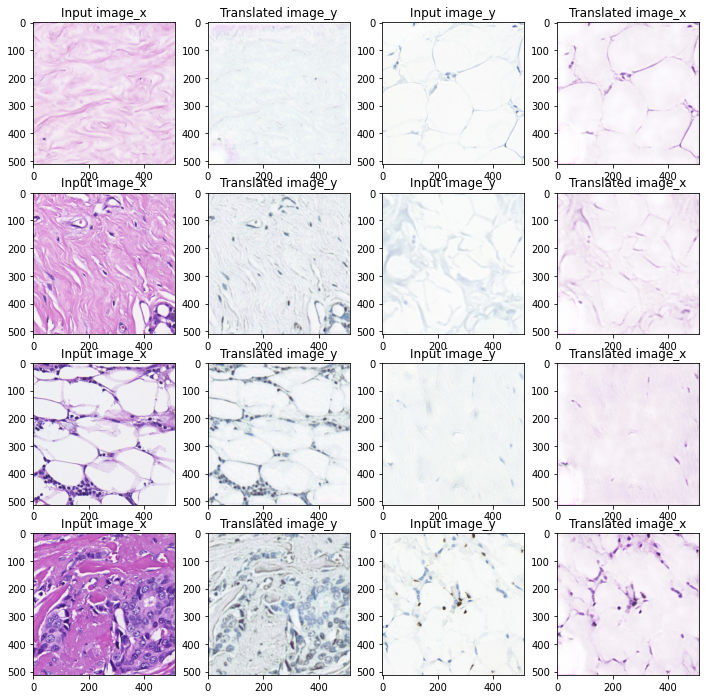

2750/2750 [==============================] - 5132s 2s/step - total_loss_G: 0.4972 - total_loss_F: 1.4879 - D_X_loss: 1.6005 - D_Y_loss: 1.2246 - generator_G_loss: 0.3543 - generator_F_loss: 1.0542 - identity_loss_G: 0.0410 - identity_loss_F: 0.1034 - cycle_loss_G: 0.1019 - cycle_loss_F: 0.3303
Epoch 2/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: 0.2296 - total_loss_F: 2.0897 - D_X_loss: 0.9537 - D_Y_loss: 0.9980 - generator_G_loss: 0.1001 - generator_F_loss: 1.6926 - identity_loss_G: 0.0330 - identity_loss_F: 0.0885 - cycle_loss_G: 0.0964 - cycle_loss_F: 0.3086

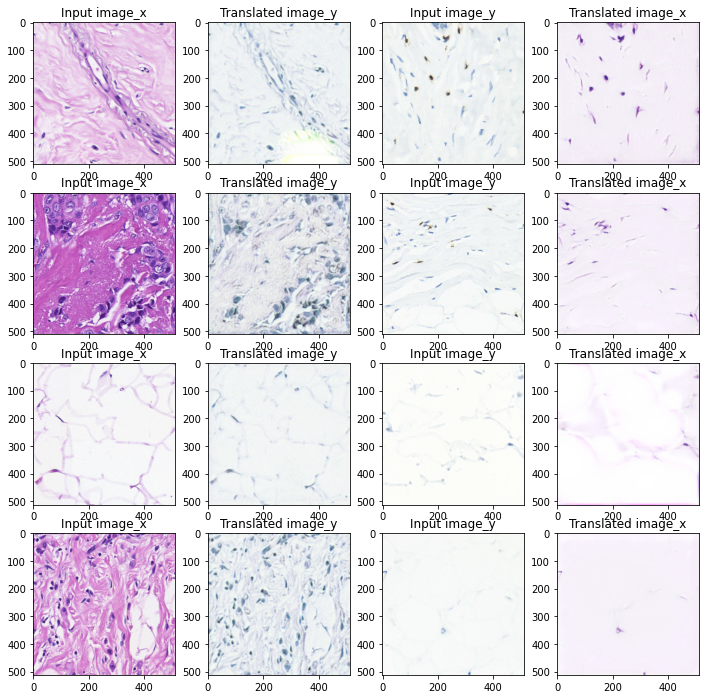

2750/2750 [==============================] - 5127s 2s/step - total_loss_G: 0.2298 - total_loss_F: 2.0907 - D_X_loss: 0.9543 - D_Y_loss: 0.9982 - generator_G_loss: 0.1004 - generator_F_loss: 1.6934 - identity_loss_G: 0.0330 - identity_loss_F: 0.0885 - cycle_loss_G: 0.0964 - cycle_loss_F: 0.3087
Epoch 3/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.7655 - total_loss_F: 3.4269 - D_X_loss: 0.4283 - D_Y_loss: 0.6466 - generator_G_loss: -0.9076 - generator_F_loss: 2.9388 - identity_loss_G: 0.0299 - identity_loss_F: 0.0941 - cycle_loss_G: 0.1122 - cycle_loss_F: 0.3940

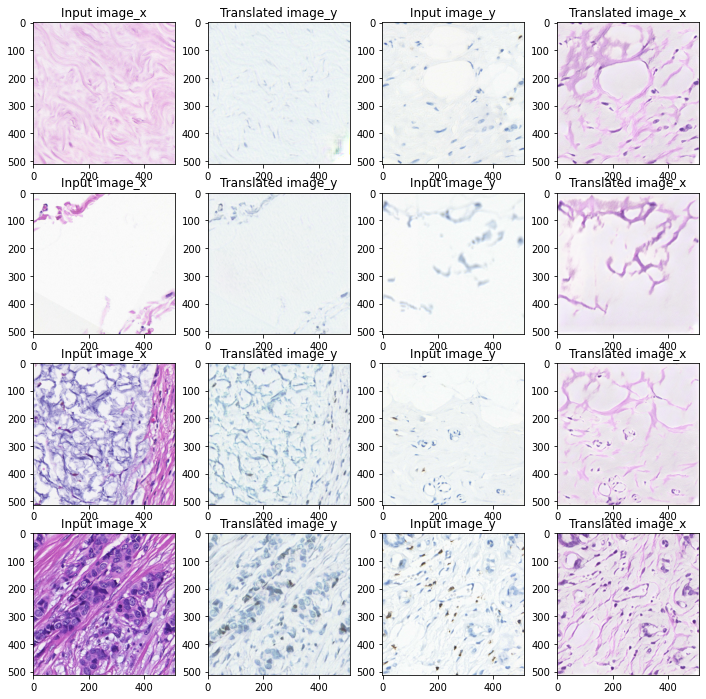

2750/2750 [==============================] - 5134s 2s/step - total_loss_G: -0.7657 - total_loss_F: 3.4273 - D_X_loss: 0.4269 - D_Y_loss: 0.6467 - generator_G_loss: -0.9079 - generator_F_loss: 2.9392 - identity_loss_G: 0.0299 - identity_loss_F: 0.0941 - cycle_loss_G: 0.1122 - cycle_loss_F: 0.3940
Epoch 4/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.9952 - total_loss_F: 9.1246 - D_X_loss: -0.7635 - D_Y_loss: 0.3369 - generator_G_loss: -1.1704 - generator_F_loss: 8.5065 - identity_loss_G: 0.0334 - identity_loss_F: 0.1150 - cycle_loss_G: 0.1417 - cycle_loss_F: 0.5031

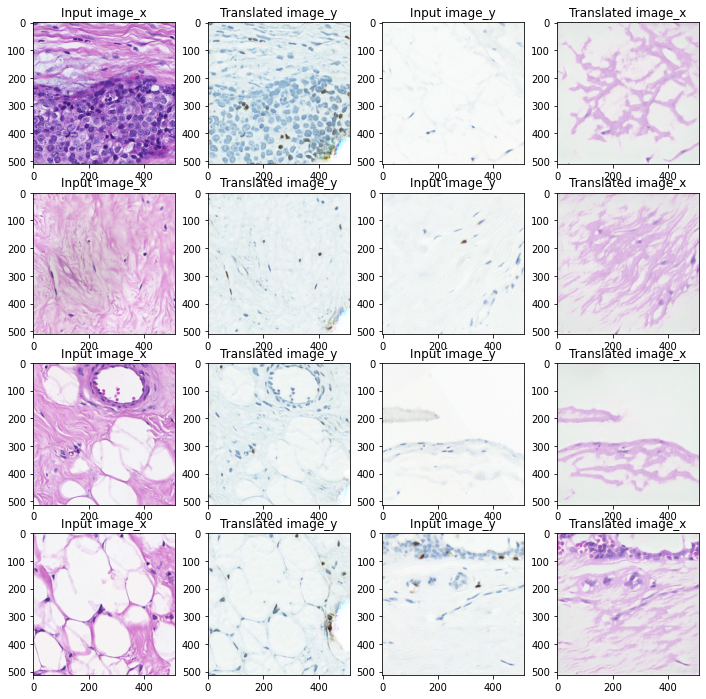

2750/2750 [==============================] - 5133s 2s/step - total_loss_G: -0.9952 - total_loss_F: 9.1269 - D_X_loss: -0.7639 - D_Y_loss: 0.3374 - generator_G_loss: -1.1704 - generator_F_loss: 8.5086 - identity_loss_G: 0.0334 - identity_loss_F: 0.1150 - cycle_loss_G: 0.1418 - cycle_loss_F: 0.5032
Epoch 5/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.7193 - total_loss_F: 13.3746 - D_X_loss: -0.0186 - D_Y_loss: 0.1059 - generator_G_loss: -0.9149 - generator_F_loss: 12.7397 - identity_loss_G: 0.0354 - identity_loss_F: 0.1103 - cycle_loss_G: 0.1602 - cycle_loss_F: 0.5246

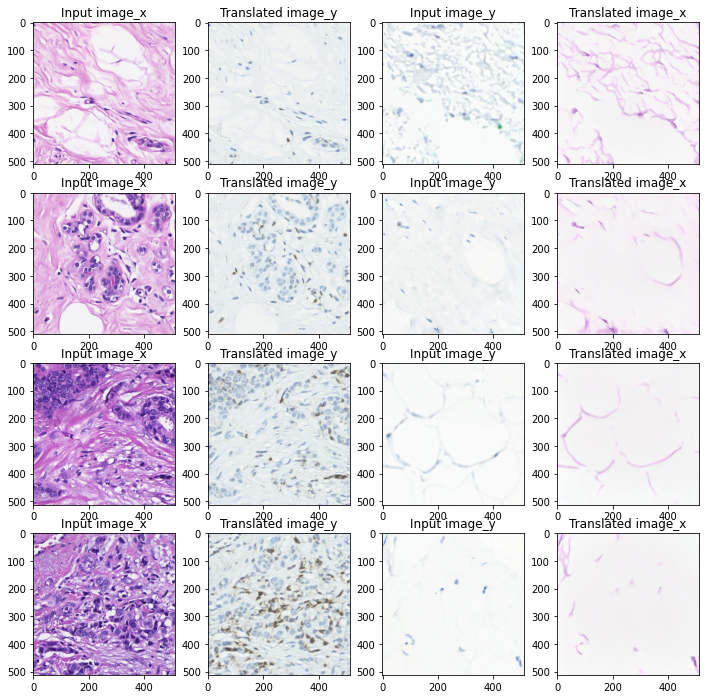

2750/2750 [==============================] - 5135s 2s/step - total_loss_G: -0.7181 - total_loss_F: 13.3724 - D_X_loss: -0.0166 - D_Y_loss: 0.1051 - generator_G_loss: -0.9137 - generator_F_loss: 12.7376 - identity_loss_G: 0.0354 - identity_loss_F: 0.1103 - cycle_loss_G: 0.1602 - cycle_loss_F: 0.5245
Epoch 6/100
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3732 - total_loss_F: 10.0046 - D_X_loss: -1.6007 - D_Y_loss: 0.2336 - generator_G_loss: -0.5672 - generator_F_loss: 9.2026 - identity_loss_G: 0.0320 - identity_loss_F: 0.1428 - cycle_loss_G: 0.1620 - cycle_loss_F: 0.6591

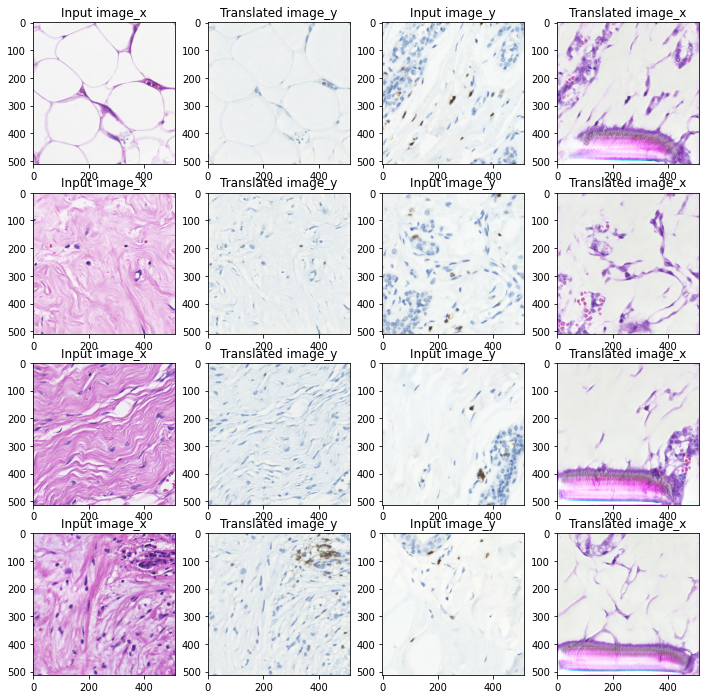

2750/2750 [==============================] - 5133s 2s/step - total_loss_G: -0.3738 - total_loss_F: 10.0050 - D_X_loss: -1.6012 - D_Y_loss: 0.2342 - generator_G_loss: -0.5678 - generator_F_loss: 9.2030 - identity_loss_G: 0.0320 - identity_loss_F: 0.1429 - cycle_loss_G: 0.1620 - cycle_loss_F: 0.6592
Epoch 7/100
 593/2750 [=====>........................] - ETA: 1:06:40 - total_loss_G: -0.9772 - total_loss_F: 13.0039 - D_X_loss: -0.9867 - D_Y_loss: 0.0157 - generator_G_loss: -1.2008 - generator_F_loss: 12.2408 - identity_loss_G: 0.0362 - identity_loss_F: 0.1486 - cycle_loss_G: 0.1874 - cycle_loss_F: 0.6145

In [ ]:
cycle_gan_model.fit(
    train_data_loader,
    epochs=100,
    callbacks=[plotter, model_checkpoint_callback],
)

# inference

In [15]:
cycle_gan_model.generator_G.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/generator_G.hdf5")
cycle_gan_model.generator_F.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/generator_F.hdf5")
cycle_gan_model.discriminator_X.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/discriminator_X.hdf5")
cycle_gan_model.discriminator_Y.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/discriminator_Y.hdf5")

In [13]:
from src.data_loader.utils import imread  
import cv2

index = 45

image_array = imread(f'./datasets/cycle_gan/HE_IHC_dataset/HE/test\\CD3CD20CD79_0303_HE\\{index}.png', channel="rgb")
target_image_array = imread(f'./datasets/cycle_gan/HE_IHC_dataset/IHC/test\\CD3CD20CD79_0303_IHC\\{index}.png', channel="rgb")

target_predicted_image_array = cv2.resize(src=image_array, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
target_predicted_image_array = np.expand_dims(target_predicted_image_array, axis=0)
target_predicted_image_array = (target_predicted_image_array / 127.5) - 1 
target_predicted_image_array = cycle_gan_model.generator_G.predict(target_predicted_image_array)[0]
target_predicted_image_array = (target_predicted_image_array + 1) * 127.5
target_predicted_image_array = target_predicted_image_array.astype("uint8")

predicted_image_array = cv2.resize(src=target_image_array, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
predicted_image_array = np.expand_dims(predicted_image_array, axis=0)
predicted_image_array = (predicted_image_array / 127.5) - 1 
predicted_image_array = cycle_gan_model.generator_F.predict(predicted_image_array)[0]
predicted_image_array = (predicted_image_array + 1) * 127.5
predicted_image_array = predicted_image_array.astype("uint8")


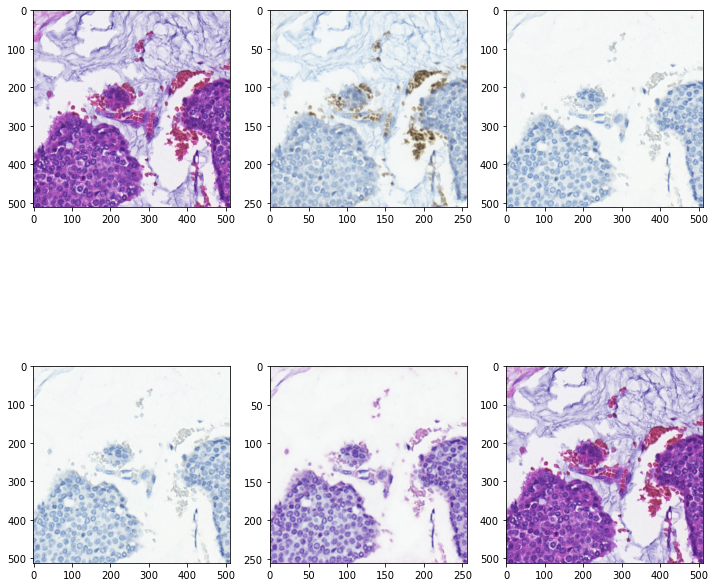

In [14]:
_, ax = plt.subplots(2, 3, figsize=(12, 12))
ax[0, 0].imshow(image_array)
ax[0, 1].imshow(target_predicted_image_array)
ax[0, 2].imshow(target_image_array)
ax[1, 0].imshow(target_image_array)
ax[1, 1].imshow(predicted_image_array)
ax[1, 2].imshow(image_array)

# Unused Code

In [23]:
image_array, target_image_array = train_data_loader[0]

In [24]:
source_array = image_array[0]
source_array = (source_array + 1) * 127.5
source_array = source_array.astype("uint8")

In [25]:
converted = generator_G(image_array)[0]
converted = np.array(converted)
converted = (converted + 1) * 127.5
converted = converted.astype("uint8")

In [26]:
temp_array = image_array[0]
temp_array = (temp_array + 1) * 127.5
temp_array = temp_array.astype("uint8")

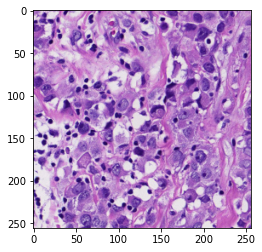

In [28]:
from matplotlib import pyplot as plt

plt.imshow(source_array)

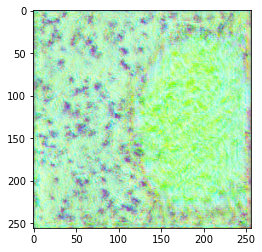

In [29]:
from matplotlib import pyplot as plt

plt.imshow(converted)

# Unused Code

In [ ]:
y_true = train_data_loader[0][0]
y_true = tf.convert_to_tensor(y_true)
one_array = np.ones((1,512,512,3))
one_diff_array = deepcopy(one_array)
one_diff_array[:,:,:,0] = 0
one_diff_array[:,:30,:30,1] = 0

one_array = tf.convert_to_tensor(one_array)
one_diff_array = tf.convert_to_tensor(one_diff_array)

In [ ]:
beta = 0.7
CHANNEL_WEIGHTED_AXIS = [1, 2]
y_true = one_array
y_pred = one_diff_array
smooth = K.epsilon()

alpha = 1 - beta
prevalence_per_channel = \
    K.mean((y_true + 1) / 2, axis=CHANNEL_WEIGHTED_AXIS)

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = \
    (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + prevalence_per_channel)

print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
print(f"channel_weighted_dice_loss: {channel_weighted_dice_loss.shape}")

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

print(f"prevalence_per_channel_shape: {prevalence_per_channel.shape}")
print(f"true_positive_shape: {tp.shape}")
print(f"false_positive_shape: {tp.shape}")
print(f"false_negative_shape: {tn.shape}")
print(f"channel_weighted_dice: {channel_weighted_dice_loss}")


In [ ]:
from tensorflow.keras import backend as K

beta=0.7
CHANNEL_WEIGHTED_AXIS=[1,2]
smooth=K.epsilon()

alpha = 1 - beta

y_true = tf.constant(image_array)
y_pred = tf.constant(image_array)

y_true = (y_true + 1 + smooth) / 2
y_pred = (y_pred + 1 + smooth) / 2

prevalence_per_channel = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

weight_per_channel = 1 / prevalence_per_channel
weight_per_channel_sum = K.sum(weight_per_channel, axis=-1)
weight_per_channel_sum = tf.expand_dims(weight_per_channel_sum, axis=-1)
weight_per_channel = weight_per_channel / weight_per_channel_sum

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + weight_per_channel)

print(channel_weighted_dice_loss)

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)